# Model Evaluation

## Import Libraries

In [20]:
from tensorflow.keras.models import load_model
import pandas as pd
from PIL import Image
import numpy as np
import cv2

from src import outputs_dir
from src.paths import model_dir, data_dir, outputs_dir

figures_dir = outputs_dir / "figures"


## Load Model

In [7]:
model = load_model(model_dir / "custom_traffic_classifier.h5")

## Load and Prepare Datasets

In [8]:
test_df = pd.read_csv(data_dir / "Test.csv")
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [14]:
from PIL import Image
import numpy as np

test_images = []
test_labels = []
skipped_images = []

for _, row in test_df.iterrows():
    image_path = data_dir / row["Path"]
    try:
        image = Image.open(image_path)
        image = image.resize((30, 30))
        test_images.append(np.array(image))
        test_labels.append(row["ClassId"])
    except Exception as e:
        skipped_images.append(image_path)
        print(f"Skipped corrupted image at {'/'.join(image_path.parts[-2:])}")

# Convert to NumPy arrays and normalize
x_test = np.array(test_images).astype("float32") / 255.0
y_test = np.array(test_labels)

Skipped corrupted image at Test/00802.png


## Predict Outputs

In [15]:
pred_probs = model.predict(x_test)
y_pred = np.argmax(pred_probs, axis=1)

  1/395 ━━━━━━━━━━━━━━━━━━━━ 1:10 180ms/step

2025-07-31 10:36:12.243910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


## Confusion Matrix & Report

Test Accuracy: 0.9363370021379365

 Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      0.98      0.98       720
           2       0.98      0.93      0.95       750
           3       0.91      0.93      0.92       450
           4       0.99      0.90      0.94       660
           5       0.80      0.96      0.87       629
           6       0.99      0.72      0.83       150
           7       0.94      0.82      0.87       450
           8       0.98      0.88      0.93       450
           9       0.90      0.98      0.94       480
          10       0.93      1.00      0.96       660
          11       0.99      0.93      0.96       420
          12       1.00      0.94      0.97       690
          13       0.98      0.98      0.98       720
          14       1.00      0.98      0.99       270
          15       0.57      1.00      0.73       210
          16       0.

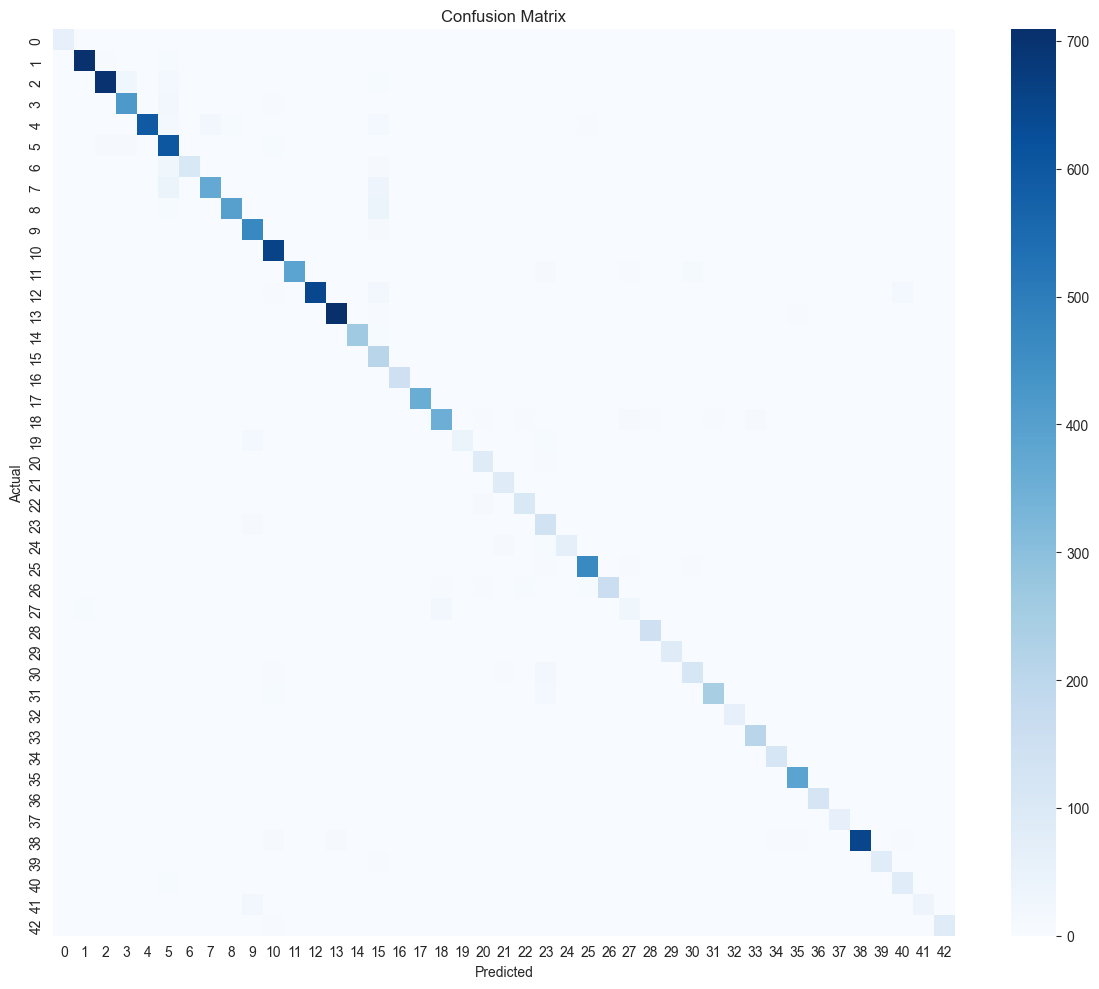

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
print("Test Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(figures_dir / "confusion_matrix.png", dpi=300)
plt.show()